# Example of MLP VAE with MNIST dataset

In [1]:
# Fist install the library

#%pip install rapidae

Since Rapidae uses the new version of Keras 3, this allows the use of different backends. 
We can select among the 3 available backends (Tensorflow, Pytorch and Jax) by modifying the environment variable "KERAS_BACKEND".
In the next cell we can define it.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import sys

notebook_dir = os.path.abspath('')
sys.path.append(os.path.join(notebook_dir, '..'))

from keras import utils
from rapidae.data.datasets import load_MNIST
from rapidae.data.utils import display_diff
from rapidae.models.base.default_architectures import Encoder_MLP, Decoder_MLP
from rapidae.models.vae.vae_model import VAE
from rapidae.pipelines.training import TrainingPipeline

# Reproducibility in Keras. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
utils.set_random_seed(1)

/home/lucaspc/venvs/keras_core/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Download and preprocess the dataset

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten number images.

The "persistant" parameter of the load_MNIST() serves as a flag to determine if we want the dataset to be cached in the datasets folder.

Train and test data are normalized.

We also need to convert the labels into one-hot encoding.

In [4]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

x_train = x_train.reshape(x_train.shape[0], -1).astype("float32") / 255
x_test = x_test.reshape(x_test.shape[0], -1).astype("float32") / 255

# Obtain number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

2023-12-28 19:20:20 [INFO]: train-images-idx3-ubyte.gz already exists.
2023-12-28 19:20:20 [INFO]: train-labels-idx1-ubyte.gz already exists.
2023-12-28 19:20:20 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2023-12-28 19:20:20 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


### Model creation

In this example we are using a vanilla MLP variational autoencoder. 

In [6]:
# Model creation
model = VAE(input_dim=x_train.shape[1], latent_dim=32,
            encoder=Encoder_MLP, decoder=Decoder_MLP, layers_conf=[128, 64])

2023-12-28 19:20:21 [INFO]: No specific dowstream task has been selected


### Training pipeline

Define the training pipeline. There you can fix some hyperparameters related to the training phase of the autoencoder, like learning rate, bath size, numer of epochs, etc.
Here you can define callbacks to the model.
Also the pipeline's name can be customized to facilitate the identification of the corresponding folder with the saved models inside output_dir folder.

In [7]:
pipe = TrainingPipeline(name='training_pipeline', learning_rate=0.01,
                        model=model, num_epochs=40, batch_size=128)

trained_model = pipe(x=x_train, y=y_train)

2023-12-28 19:20:21 [INFO]: +++ training_pipeline +++
2023-12-28 19:20:21 [INFO]: Creating folder in ../output_dir/training_pipeline_2023-12-28_19-20-21


Epoch 1/40

Epoch 1: loss improved from inf to 0.07721, saving model to ../output_dir/training_pipeline_2023-12-28_19-20-21/model.weights.h5
469/469 - 3s - 6ms/step - kl_loss: 0.0080 - loss: 0.0772 - reconstruction_loss: 0.0692
Epoch 2/40

Epoch 2: loss improved from 0.07721 to 0.06751, saving model to ../output_dir/training_pipeline_2023-12-28_19-20-21/model.weights.h5
469/469 - 3s - 5ms/step - kl_loss: 4.3210e-09 - loss: 0.0675 - reconstruction_loss: 0.0675
Epoch 3/40

Epoch 3: loss improved from 0.06751 to 0.06744, saving model to ../output_dir/training_pipeline_2023-12-28_19-20-21/model.weights.h5
469/469 - 2s - 5ms/step - kl_loss: 8.8962e-10 - loss: 0.0674 - reconstruction_loss: 0.0674
Epoch 4/40

Epoch 4: loss improved from 0.06744 to 0.06740, saving model to ../output_dir/training_pipeline_2023-12-28_19-20-21/model.weights.h5
469/469 - 3s - 5ms/step - kl_loss: 4.4481e-10 - loss: 0.0674 - reconstruction_loss: 0.0674
Epoch 5/40

Epoch 5: loss improved from 0.06740 to 0.06738, savi

### Evaluation step

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


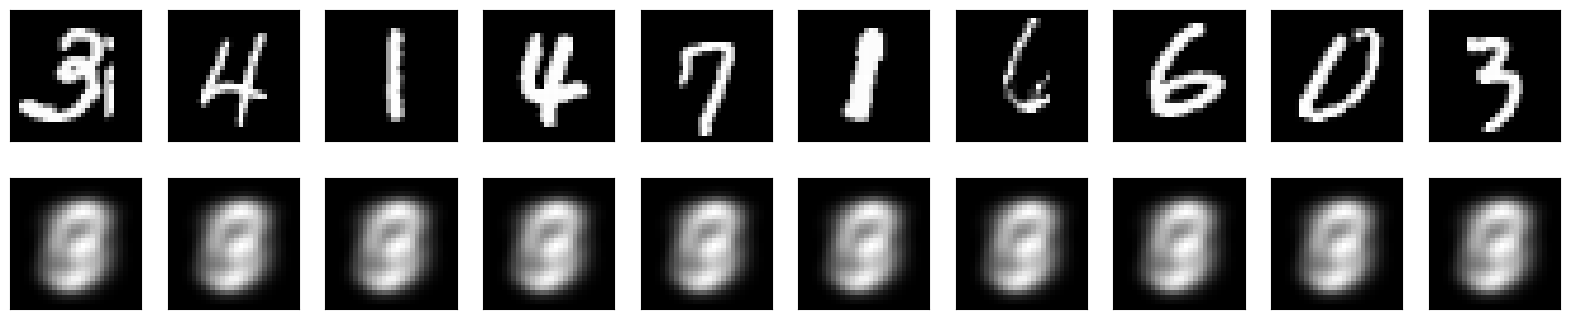

In [8]:
y_hat = trained_model.predict(x_test)

display_diff(x_test, y_hat['recon'])